In [0]:
# the Intel Images Classification is available at this link https://www.kaggle.com/puneet6060/intel-image-classification

In [0]:
!pip install hypopt

In [0]:
!pip install matplotlib==3.1.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile

with zipfile.ZipFile('/content/drive/My Drive/intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/intel-image-classification')

# **Libraries**

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# Importing hypopt library for grid search 
from hypopt import GridSearch

# Importing Keras libraries 
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from keras.utils.vis_utils import model_to_dot
import cv2
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from scipy import ndimage
import random
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Functions

### Randomly extraction of a sample of the images

In [0]:
def get_images(directory, N):
    
  Images = []
  Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
  
  dict_classes = {"buildings": 0, "forest":1, "glacier":2,"mountain":3,"sea":4,"street":5}
  
  for labels in os.listdir(directory): 

    label = dict_classes[labels]
    path = []
    
    image_sample = random.sample(os.listdir(directory+labels), k = int(N/6))
    
    for random_path in image_sample:
      
      image = cv2.imread(directory+labels+"/"+random_path) #Reading the image (OpenCV)
      image = cv2.resize(image,(224,224)) #Resize the image
      image = np.expand_dims(image, axis=0)
      image = preprocess_input(image)
      Images.append(image)
      Labels.append(label)
        
            
  return shuffle(Images,Labels,random_state=12345)

### Getting classes labels

In [0]:
def get_classlabel(class_code):
    
    labels = {"buildings": 0, "forest":1, "glacier":2,"mountain":3,"sea":4,"street":5}
    
    return labels[class_code]

### Features extraction 

In [0]:
def feature_list(data, model):

  feature_list = []

  for img_data in data:
    
    feature = model.predict(img_data)
    feature_np = np.array(feature)
    feature_list.append(feature_np.flatten())
 
  feature_list_np = np.array(feature_list)
  
  return  feature_list_np

### Grid Serach for parameter optimization (Logistic Regression)

In [0]:
'''
def GridSearch_logistic(feature_list_np, val_features_flatten):

  #param_grid = [{'C': [0.1,1,10],'solver': ['newton-cg','lbfgs']}]
  param_grid = [{'C': [10],'solver': ['lbfgs']}]
 
# Grid-search all parameter combinations using a validation set.
  opt = GridSearch(model = LogisticRegression(class_weight='balanced', multi_class="auto",
                          max_iter=200, random_state=1),param_grid = param_grid)
  
  opt.fit(feature_list_np, train_y, val_features_flatten, val_y, scoring = 'accuracy')

  opt.get_best_params()

  return opt

'''

'\ndef GridSearch_logistic(feature_list_np, val_features_flatten):\n\n  #param_grid = [{\'C\': [0.1,1,10],\'solver\': [\'newton-cg\',\'lbfgs\']}]\n  param_grid = [{\'C\': [10],\'solver\': [\'lbfgs\']}]\n \n# Grid-search all parameter combinations using a validation set.\n  opt = GridSearch(model = LogisticRegression(class_weight=\'balanced\', multi_class="auto",\n                          max_iter=200, random_state=1),param_grid = param_grid)\n  \n  opt.fit(feature_list_np, train_y, val_features_flatten, val_y, scoring = \'accuracy\')\n\n  opt.get_best_params()\n\n  return opt\n\n'

### Predictions and results 

In [0]:
def opt_preds(opt, features_flatten, label):

  class_labels = ["buildings", "forest", "glacier","mountain","sea","street"] 

  opt.score(features_flatten, label)
  preds = opt.predict(features_flatten)
  print("\nAccuracy:: ", accuracy_score(label, preds))
  print("\nNumber of correctly identified imgaes: ",
        accuracy_score(label, preds, normalize=False)," out of ", 
        len(features_flatten),"\n")

  %matplotlib inline
  matrix = confusion_matrix(label, preds)

  plt.figure(figsize=(6, 5))
  ax = sns.heatmap(matrix,annot=True,cbar=True,cmap="YlGnBu", fmt="d")

  plt.tight_layout()

  locs_x, labels_x=plt.xticks()
  x_ticks = []
  plt.xticks(locs_x,class_labels, rotation=45)

  locs_y, labels_y=plt.yticks()
  y_ticks = []
  plt.yticks(locs_y,class_labels, rotation=0)


  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title('Confusion Matrix')

  plt.show()

  return preds

## Import of images

### Train and Test

In [0]:
train, train_y = get_images('/content/intel-image-classification/seg_train/seg_train/', 2000)
test, test_y = get_images('/content/intel-image-classification/seg_test/seg_test/', 1000) 


#Creating a validation, if we need it

#val, val_y = train[-300:], train_y[-300:]
#train, train_y = train[:-300], train_y[:-300]

Training data available in 6 classes
[333, 333, 333, 333, 333, 333]


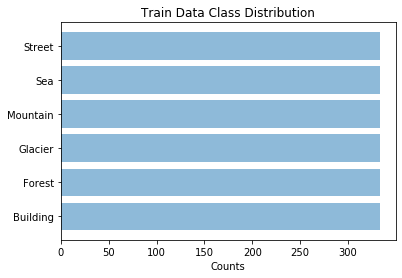

In [0]:
print("Training data available in 6 classes")
print([train_y.count(i) for i in range(0,6)])

intel_classes = ('Building','Forest','Glacier','Mountain','Sea','Street')

y_pos = np.arange(len(intel_classes))
counts = [train_y.count(i) for i in range(0,6)]

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, intel_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')

plt.show()

In [0]:
print("Test data available in 6 classes")
[test_y.count(i) for i in range(0,6)]

Test data available in 6 classes


[166, 166, 166, 166, 166, 166]

## **Import of the VGG16 model**


In [0]:
from keras.models import Model

model = VGG16(weights="imagenet")

## First experiment: VGG16 up to block4_pool (MaxPooling2D)

In [0]:
model_1 = Model(model.input, model.layers[-9].output)
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
train_feature_list_np = feature_list(train, model_1)
#val_features_flatten = feature_list(val, model_1)
test_features_flatten = feature_list(test, model_1)

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=1234, 
                         solver='newton-cg', 
                         multi_class='multinomial',
                         max_iter=200)

In [0]:
clf_fit = clf.fit(train_feature_list_np, train_y)

In [0]:
#opt = GridSearch_logistic(train_feature_list_np, val_features_flatten)


Accuracy::  0.8755020080321285

Number of correctly identified imgaes:  872  out of  996 



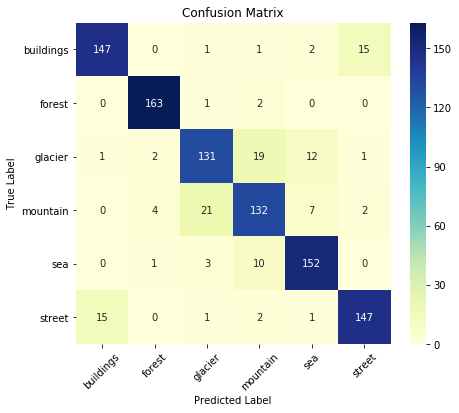

In [0]:
preds = opt_preds(clf_fit, test_features_flatten, test_y)


Accuracy::  1.0

Number of correctly identified imgaes:  1998  out of  1998 



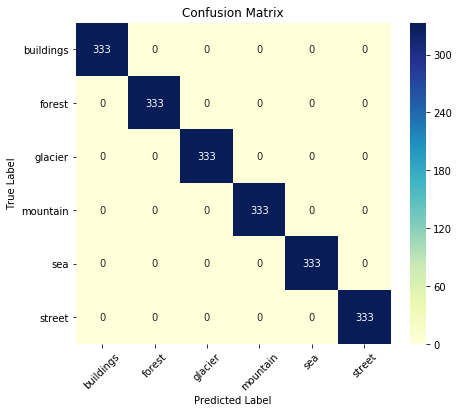

In [0]:
preds_train = opt_preds(clf_fit, train_feature_list_np, train_y)

In [0]:
from sklearn.metrics import classification_report
print("Results on Test \n", classification_report(test_y, preds, target_names=intel_classes))
print(" \nResults on Train \n", classification_report(train_y, preds_train, target_names=intel_classes))

Results on Test 
               precision    recall  f1-score   support

    Building       0.90      0.89      0.89       166
      Forest       0.96      0.98      0.97       166
     Glacier       0.83      0.79      0.81       166
    Mountain       0.80      0.80      0.80       166
         Sea       0.87      0.92      0.89       166
      Street       0.89      0.89      0.89       166

    accuracy                           0.88       996
   macro avg       0.87      0.88      0.88       996
weighted avg       0.87      0.88      0.88       996

 
Results on Train 
               precision    recall  f1-score   support

    Building       1.00      1.00      1.00       333
      Forest       1.00      1.00      1.00       333
     Glacier       1.00      1.00      1.00       333
    Mountain       1.00      1.00      1.00       333
         Sea       1.00      1.00      1.00       333
      Street       1.00      1.00      1.00       333

    accuracy                          

## Second experiment: VGG16 up to block5_pool (MaxPooling2D)

In [0]:
model_2 = Model(model.input, model.layers[-5].output)
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
train_feature_list_np_2 = feature_list(train, model_2)
#val_features_flatten_2 = feature_list(val, model_2)
test_features_flatten_2 = feature_list(test, model_2)

In [0]:
clf_fit_2 = clf.fit(train_feature_list_np_2, train_y)

In [0]:
#opt_2 = GridSearch_logistic(train_feature_list_np_2, val_features_flatten_2)


Accuracy::  0.8985943775100401

Number of correctly identified imgaes:  895  out of  996 



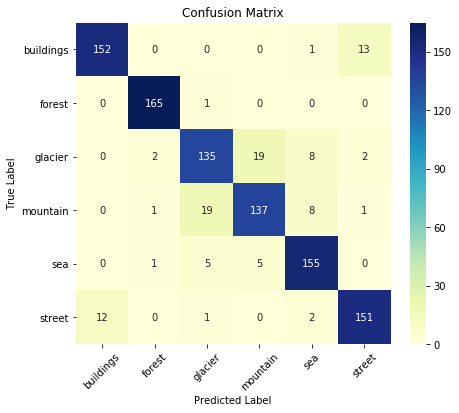

In [0]:
preds_2 = opt_preds(clf_fit_2, test_features_flatten_2, test_y)


Accuracy::  1.0

Number of correctly identified imgaes:  1998  out of  1998 



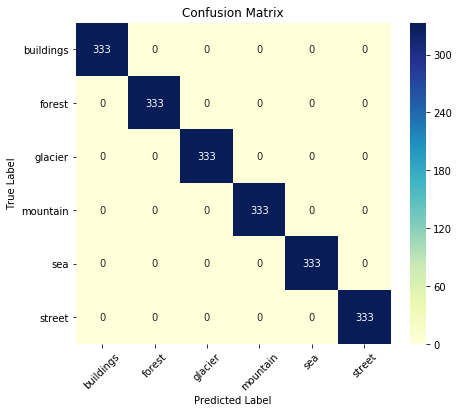

In [0]:
preds_2_train = opt_preds(clf_fit_2, train_feature_list_np_2, train_y)

In [0]:
print("Results on Test \n", classification_report(test_y, preds_2, target_names=intel_classes))
print(" \nResults on Train \n", classification_report(train_y, preds_2_train, target_names=intel_classes))

Results on Test 
               precision    recall  f1-score   support

    Building       0.93      0.92      0.92       166
      Forest       0.98      0.99      0.99       166
     Glacier       0.84      0.81      0.83       166
    Mountain       0.85      0.83      0.84       166
         Sea       0.89      0.93      0.91       166
      Street       0.90      0.91      0.91       166

    accuracy                           0.90       996
   macro avg       0.90      0.90      0.90       996
weighted avg       0.90      0.90      0.90       996

 
Results on Train 
               precision    recall  f1-score   support

    Building       1.00      1.00      1.00       333
      Forest       1.00      1.00      1.00       333
     Glacier       1.00      1.00      1.00       333
    Mountain       1.00      1.00      1.00       333
         Sea       1.00      1.00      1.00       333
      Street       1.00      1.00      1.00       333

    accuracy                          

## Third experiment: VGG16 up to fc1 (Dense)

In [0]:
model_3 = Model(model.input, model.layers[-3].output)
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
train_feature_list_np_3 = feature_list(train, model_3)
#val_features_flatten_3 = feature_list(val, model_3)
test_features_flatten_3 = feature_list(test, model_3)

In [0]:
clf_fit_3 = clf.fit(train_feature_list_np_3, train_y)

In [0]:
#opt_3 = GridSearch_logistic(train_feature_list_np_3, val_features_flatten_3) 


Accuracy::  0.8995983935742972

Number of correctly identified imgaes:  896  out of  996 



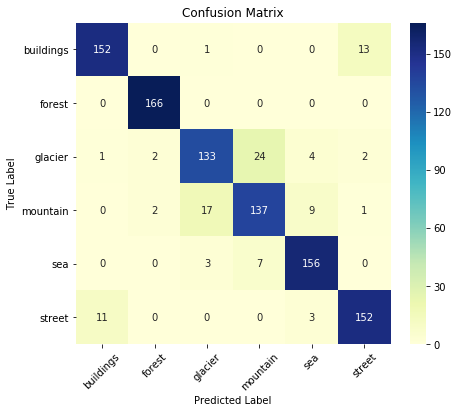

In [0]:
preds_3 = opt_preds(clf_fit_3, test_features_flatten_3, test_y)


Accuracy::  1.0

Number of correctly identified imgaes:  1998  out of  1998 



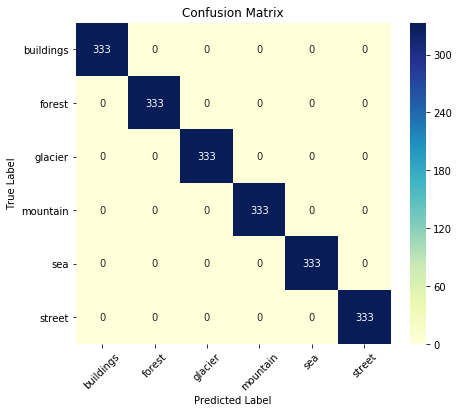

In [0]:
preds_3_train = opt_preds(clf_fit_3, train_feature_list_np_3, train_y)

In [0]:
print("Results on Test \n", classification_report(test_y, preds_3, target_names=intel_classes))
print(" \nResults on Train \n", classification_report(train_y, preds_3_train, target_names=intel_classes))

Results on Test 
               precision    recall  f1-score   support

    Building       0.93      0.92      0.92       166
      Forest       0.98      1.00      0.99       166
     Glacier       0.86      0.80      0.83       166
    Mountain       0.82      0.83      0.82       166
         Sea       0.91      0.94      0.92       166
      Street       0.90      0.92      0.91       166

    accuracy                           0.90       996
   macro avg       0.90      0.90      0.90       996
weighted avg       0.90      0.90      0.90       996

 
Results on Train 
               precision    recall  f1-score   support

    Building       1.00      1.00      1.00       333
      Forest       1.00      1.00      1.00       333
     Glacier       1.00      1.00      1.00       333
    Mountain       1.00      1.00      1.00       333
         Sea       1.00      1.00      1.00       333
      Street       1.00      1.00      1.00       333

    accuracy                          